# ABOUT THIS NOTEBOOK
## Purpose
This notebook attempts to fit various machine learning models on the data set.    
Results of the model fitting are analyzed.
## Input
'data_set.pickle' generated by 'data_processing.ipynb'.
## Output
Results of model fitting: parameters and scores.
## Tasks Performed
* Load library packages
* Load pickle file
* Split data into train & test sets
    * Train: weeks 1 & 2, Test: week 3
    * Perform feature scaling
* Implement functions for common tasks
    * Scoring
    * Learning curves
    * Cross validation
    * Hyperparameter selection
* Fit models
    * Linear
    * Random Forest Regressor
    * K-Nearest Neighbors

# LOAD LIBRARY PACKAGES

In [1]:
# Import the required library packages
import os
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from six.moves import cPickle as pickle

print 'Read in packages from os, numpy, pandas, matplotlib, seaborn, sklearn & six'

Read in packages from os, numpy, pandas, matplotlib, seaborn, sklearn, scipy & six


# LOAD PICKLE FILE

In [2]:
pickle_file = 'data_set.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save
    print 'Loaded ptrain_set', pdata_set.shape
    
f.close()

Loaded ptrain_set (199584, 55)


In [3]:
pdata_set.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# SPLIT DATA INTO TRAIN & TEST SETS

## Use weeks 1 & 2 for training, week 3 for test

In [4]:
train_days     = range(1,15)
test_days      = range(15, 22)

X_train     = pdata_set[(pdata_set['num_day'].isin(train_days))]
X_test      = pdata_set[(pdata_set['num_day'].isin(test_days))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (133056, 55) (66528, 55) 




## Generate scaled features for train & test sets

In [5]:
import warnings
warnings.filterwarnings('ignore')

gap_predictors = ['demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3',
                  'poi_pc1', 'poi_pc2',
                  'tj_lvl1', 'tj_lvl2', 'tj_lvl3',
                  'ts_0', 'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7',
                  'pollution', 'temperature',
                  'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3'
                 ]  

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Use StandardScaler to achieve zero mean and unit variance
# Generate two scalers: input and target
input_scaler = StandardScaler().fit(pdata_set[gap_predictors])
target_scaler = StandardScaler().fit(pdata_set['gap'])

# Scale both training & test data
gX_train  = input_scaler.transform(X_train[gap_predictors])
gy_train  = target_scaler.transform(X_train['gap'])

gX_test = input_scaler.transform(X_test[gap_predictors])
gy_test = target_scaler.transform(X_test['gap'])

# IMPLEMENT FUNCTIONS FOR COMMON TASKS

In [63]:
def mape_score(exp, pred, q):
    
    """
    Generate the MAPE score value.

    Parameters
    ----------
    exp  : Array containing expected values
    pred : Array containing predicted values
    q    : Constant representing (number of days * number of time slots) - 1
    """
    
    mape = 0.0
    n = 66.0
    
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))


def print_score(y_train, y_pred_train, y_test, y_pred_test):
    
    """
    Present the MSE, R^2 and MAPE scores for train & test sets as a table.

    Parameters
    ----------
    y_train      : Array containing expected values for train set
    y_pred_train : Array containing predicted values for train set
    y_test       : Array containing expected values for test set
    y_pred_test  : Array containing predicted values for test set
    """
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    # Assumes data is for 144 time slots, 14 days (train), 6 days (test)
    mpscore_train    = mape_score(y_train,    y_pred_train, ((144*14)-1))
    mpscore_test     = mape_score(y_test,     y_pred_test, ((144*6)-1))


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'

    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.2f}\t\t{2:.2f}\t\t{3:.2f}' .format(s, m, r, mp)

        
def eval_score(y_train, y_pred_train, y_test, y_pred_test):
        
    """
    Present the MSE, R^2 and MAPE scores for train & test sets as a table.

    Parameters
    ----------
    y_train      : Array containing expected values for train set
    y_pred_train : Array containing predicted values for train set
    y_test       : Array containing expected values for test set
    y_pred_test  : Array containing predicted values for test set
    """
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    mpscore_train    = mape_score(y_train,    y_pred_train, ((144*14)-1))
    mpscore_test     = mape_score(y_test,     y_pred_test, ((144*6)-1))


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'


    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.2f}\t\t{2:.2f}\t\t{3:.2f}' .format(s, m, r, mp)

In [64]:
# Create a scorer function using the MAPE metric
# Use the training data size (144 time slots * 14 days) for q value
from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mape_score, greater_is_better=False, q=((144*14)-1))

In [65]:
def predict_score(train_set, test_set, predictors, exp_col, fitfunc, *fitargs):

    """
    Generate predictions, evaluate scores and present results.

    Parameters
    ----------
    train_set  : Dataframe for train set
    test_set   : Dataframe for test set
    predictors : Array containing columns representing the input features to be used for prediction
    exp_col    : Column name containing the expected value 
    fitfunc    : Model used for fitting
    fitargs    : Arguments passed to the model
    """
        
    # Generate dataframe for train & test
    Xtrain_df    = train_set[predictors]
    Xtest_df     = test_set[predictors]
    
    # Generate predictions for train & test
    y_pred_train    = fitfunc(Xtrain_df,    *fitargs)
    y_pred_test     = fitfunc(Xtest_df,     *fitargs)

    # Extract expected train & test values
    y_train    = train_set[exp_col]
    y_test     = test_set[exp_col]

    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    mpscore_train    = mape_score(y_train,    y_pred_train, ((144*14)-1))
    mpscore_test     = mape_score(y_test,     y_pred_test, ((144*6)-1))


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'


    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.2f}\t\t{2:.2f}\t\t{3:.2f}' .format(s, m, r, mp)
    
    return(y_pred_train, y_pred_test)

## LEARNING CURVES

In [66]:
from sklearn.learning_curve import validation_curve

def plot_validation_curve(estimator, X, y, param_name, param_range, 
                          scoring, plot_title, x_label, y_label, n_jobs=-1):
    
    # Cross validation with 25 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=25, test_size=0.2, random_state=0)
    
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range,
                                                 cv=cv, scoring=scoring, n_jobs=n_jobs)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

In [67]:
from sklearn import cross_validation
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curves.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

    title : string
            Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
           Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
         If an integer is passed, it is the number of folds (defaults to 3).
         Specific cross-validation objects can be passed, see
         sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
             Number of jobs to run in parallel (default 1).
             
    train_sizes : array, optional
                  Sizes of train set to use for generating the learning curve plot 
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2 Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## DEMAND, SUPPLY PREDICTIONS & GAP FORECASTING

In [68]:
def analyze_error(gapy_pred_train, gapy_pred_test):
    
    Xerr_train = pd.DataFrame()
    Xerr_test  = pd.DataFrame()
    
    Xerr_train = X_train.copy()
    Xerr_test  = X_test.copy()
    
    # Drop columns that will not be used for analysis
    Xerr_train.drop(['weather', 'temperature', 'pollution', 
                     'demand_t-1', 'demand_t-2', 'demand_t-3', 
                     'supply_t-1', 'supply_t-2', 'supply_t-3'],
                    axis=1, inplace=True)
    
    Xerr_test.drop(['weather', 'temperature', 'pollution', 
                    'demand_t-1', 'demand_t-2', 'demand_t-3', 
                    'supply_t-1', 'supply_t-2', 'supply_t-3'], 
                   axis=1, inplace=True)
    
    
    # Create new columns that store errors
    Xerr_train['gap_error'] = X_train['gap']    - gapy_pred_train
    Xerr_test['gap_error'] = X_test['gap']    - gapy_pred_test
    
    print '\nTrain error correlation matrix:\n', Xerr_train.corr()
    print '\nTest error correlation matrix:\n', Xerr_test.corr()    
  
    print '\nTest Error Joint Plot\n'
    for y in ['demand', 'gap', 'supply', 'district_id', 'num_day', 'time_slot', 'week_day', 'poi_cluster', 'congestion']:
        g = sns.jointplot('gap_error', y, data=Xerr_train, kind="reg",color="r", size=3)
    plt.show()
    
    print '\nTrain Error Joint Plot\n'
    for y in ['demand', 'gap', 'supply', 'district_id', 'num_day', 'time_slot', 'week_day', 'poi_cluster', 'congestion']:
        g = sns.jointplot('gap_error', y, data=Xerr_test, kind="reg",color="r", size=3)
    plt.show()

In [69]:
# Generate Demand Supply Gap Metrics based on provided fit functions
# Assumes expected values for gap is in namesake column
def gap_estimate(**kwargs):
    
    gX_train     = kwargs["gX_train"]
    gX_test      = kwargs["gX_test"]
    g_fitfunc    = kwargs["g_fitfunc"]
    
    print "\n\nGAP FORECASTING"
    print     "==============="

    # Generate predictions for train & test sets
    gy_pred_train    = gap_scaler.inverse_transform(g_fitfunc.predict(gX_train))
    gy_pred_test     = gap_scaler.inverse_transform(g_fitfunc.predict(gX_test))

    # Extract expected train & test values
    gy_train    = X_train['gap']
    gy_test     = X_test['gap']

    # Evaluate scores and print results
    print_score(gy_train, gy_pred_train, gy_test, gy_pred_test)
   
    #analyze_error(gy_pred_train, gy_pred_test)
    
    return


# Generate Demand Supply Gap Metrics based on provided fit functions
# Assumes expected values for demand, supply, gap are in namesake columns
def gap_forecast(**kwargs):
    
    X_train      = kwargs["train_set"]
    X_test       = kwargs["test_set"]
    r_predictors = kwargs["demand_predictors"]
    a_predictors = kwargs["supply_predictors"]
    r_fitfunc    = kwargs["rfit_func"]
    r_fitargs    = kwargs["rfit_args"]
    a_fitfunc    = kwargs["afit_func"]
    a_fitargs    = kwargs["afit_args"]
    
    print "\n\nDEMAND FORECASTING"
    print     "=================="

    ry_pred_train, ry_pred_test = predict_score(X_train, X_test, r_predictors, 'demand', r_fitfunc, *r_fitargs)

    print "\n\nSUPPLY FORECASTING"
    print     "=================="

    ay_pred_train, ay_pred_test = predict_score(X_train, X_test, a_predictors, 'supply', a_fitfunc, *a_fitargs)

    print "\n\nGAP FORECASTING"
    print     "==============="

    gapy_pred_train    = [r - a for r, a in zip(ry_pred_train,    ay_pred_train)]
    gapy_pred_test     = [r - a for r, a in zip(ry_pred_test,     ay_pred_test)]

    gapy_train    = X_train['gap']
    gapy_test     = X_test['gap']

    eval_score(gapy_train, gapy_pred_train, gapy_test, gapy_pred_test)
    
    return

In [70]:
# Generate learning curves by varying training sizes
# Use Training vs Cross-validation curves
def generate_learningcurves(**kwargs):    
   
    gX_train      = kwargs["gX_train"]
    gy_train      = kwargs["gy_train"]
        
    alg           = kwargs["alg"]
    alg_name      = kwargs["alg_name"]
          
    # Plot learning curve - Demand
    X, y = gX_train, gy_train

    title = 'Learning Curves for Gap (' + alg_name + ')'

    # Cross validation with 25 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=25, test_size=0.2, random_state=0)

    estimator = alg
    plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(.01, 1.0, 20))
    plt.show()

In [71]:
# Generate learning curves by varying training sizes
# Use Training vs Cross-validation curves
def generate_traintestscores(**kwargs):    
   
    gX_train      = kwargs["gX_train"]
    gy_train      = kwargs["gy_train"]
    gX_test       = kwargs["gX_test"]
    gy_test       = kwargs["gy_test"]
        
    alg           = kwargs["alg"]
    alg_name      = kwargs["alg_name"]
    
    # Create training set of increasing sizes
    train_size_set = [10000, 20000, 40000, 60000, 80000, 93324]

    Xg_train_set = []
    yg_train_set = []   
    Xg_test = gX_test
    yg_test = gy_test


    for size in train_size_set: 
        Xg_train_set.append(gX_train[:size])
        yg_train_set.append(gy_train[:size])
    
    # Train Gap Forecaster
    print ('\nTraining Gap Forecaster - {}\n' .format(alg_name))

    for train_size, Xg_train, yg_train in zip(train_size_set, Xg_train_set, yg_train_set):
        clf = alg.fit(Xg_train, yg_train)
    
        # Scores
        train_score = clf.score(Xg_train, yg_train)
        test_score  = clf.score(Xg_test, yg_test)
        print ('Train Size: {0:.3f} Train Score: {1:.3f} Test Score: {2:.3f}' .format(train_size, train_score, test_score))

In [72]:
def select_hyperparams(**kwargs):
    
    gX_train      = kwargs['gX_train']
    gy_train      = kwargs['gy_train']
    gX_test       = kwargs["gX_test"]
    gy_test       = kwargs["gy_test"]

    
    alg           = kwargs['alg']
    alg_name      = kwargs['alg_name']
    param_grid    = kwargs['param_grid']
    scoring_func  = kwargs['scoring_func']
    
    # GAP
    # Use nested cross validation - 5x2 cross validation

    g_gs = GridSearchCV(estimator=alg,
                  param_grid=param_grid,
                  scoring=scoring_func,
                  cv=2,
                  n_jobs=-1)

    scores = cross_val_score(estimator=g_gs,
                         X=gX_train,
                         y=gy_train,
                         scoring=scoring_func,
                         cv=5)

    g_gs = g_gs.fit(X=gX_train, y=gy_train)

    print 'Best Estimator (Demand):\n', g_gs.best_estimator_
    print('CV accuracy (Demand): %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
   
    # Generate Learning Curves - Demand & Supply
    generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                            alg=g_gs.best_estimator_, alg_name=alg_name)
    
    generate_traintestscores(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                             alg=g_gs.best_estimator_, alg_name=alg_name)
    
    # Print Scores   
    gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

# NEURAL NETS - Tensor Flow

# RANDOM FORESTS

## Default Parameters

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Random Forests only supports MSE score for deciding splits
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=RandomForestRegressor(), alg_name="Random Forests")

generate_traintestscores(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                         alg=RandomForestRegressor(), alg_name="Random Forests")

## Hyper Parameter Selection

In [ ]:
# Use GridSearchCV - Demand
# Specify parameters
param_grid = {'n_estimators'      : [50],
              'max_features'      : [0.75, 1.0],
              'max_depth'         : [3],
              'min_samples_split' : [3],
              'random_state'      : [0]}
             
alg = RandomForestRegressor()

# Only mse is supported for the RandomForestRegressor
# Use MAPE as scoring function for GridSearchCV, cross_val_score
select_hyperparams(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                   alg=alg, alg_name='Random Forests', param_grid=param_grid, scoring_func=mape_scorer)

# DECISION TREES

## Default Parameters

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Decision Trees only supports MSE score for deciding splits
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=DecisionTreeRegressor(), alg_name="Decision Trees")

generate_traintestscores(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                         alg=DecisionTreeRegressor(), alg_name="Decision Trees")

## Hyper Parameter Selection

In [ ]:
# Use GridSearchCV - Gap
# Specify parameters
param_grid = {'max_features'      : [0.25, 0.5, 0.75, 1.0],
              'max_depth'         : [5, 10, 15, 20, 25],
              'min_samples_split' : [2, 3, 4, 5, 10],
              'random_state'      : [0]}
             
alg = DecisionTreeRegressor()

# Only mse is supported for the DecisionTreeRegressor
# Use MAPE as scoring function for GridSearchCV, cross_val_score
select_hyperparams(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                   alg=alg, alg_name='Decision Trees', param_grid=param_grid, scoring_func=mape_scorer)

# K NEAREST NEIGHBORS

## Default Parameters

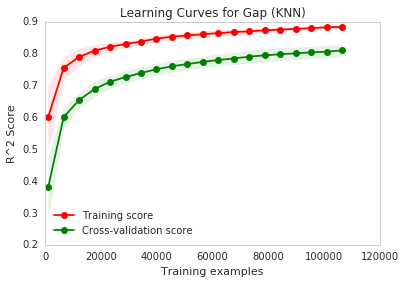


Training Gap Forecaster - KNN

Train Size: 10000.000 Train Score: 0.743 Test Score: 0.178
Train Size: 20000.000 Train Score: 0.879 Test Score: 0.664
Train Size: 40000.000 Train Score: 0.881 Test Score: 0.675
Train Size: 60000.000 Train Score: 0.886 Test Score: 0.722
Train Size: 80000.000 Train Score: 0.889 Test Score: 0.734
Train Size: 93324.000 Train Score: 0.892 Test Score: 0.739


In [73]:
from sklearn.neighbors import KNeighborsRegressor

# KNN defaults to R^2 score
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=KNeighborsRegressor(), alg_name="KNN")

generate_traintestscores(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                         alg=KNeighborsRegressor(), alg_name="KNN")

## Hyper Parameter Selection

In [ ]:
# Scaling for input features
# Generate scaled features for train & test sets

import warnings
warnings.filterwarnings('ignore')

few_predictors = ['demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3',
                  'weekday_0', 'weekday_1', 'weekday_2',
                  'ts_7', 'ts_6', 'ts_5', 'ts_4', 'ts_3', 'ts_2', 'ts_1', 'ts_0',
                  'dist_6', 'dist_5', 'dist_4', 'dist_3', 'dist_2', 'dist_1', 'dist_0'] 

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Normalize features - both training & test
g_scaler = StandardScaler().fit(ptrain_set[few_predictors])
gap_scaler = StandardScaler().fit(ptrain_set['gap'])

# Input Samples and Target Values for Gap(g)
gX_train  = g_scaler.transform(X_train[few_predictors])
gy_train  = gap_scaler.transform(X_train['gap'])

gX_test = g_scaler.transform(X_test[few_predictors])
gy_test = gap_scaler.transform(X_test['gap'])

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

plot_validation_curve(estimator=KNeighborsRegressor(), X=gX_train, y=gy_train, 
                      param_name='n_neighbors', param_range=[3,10,30,100,300,1000], 
                      scoring='r2', plot_title='KNN', x_label='# of neighbors', y_label='r2', 
                      n_jobs=-1)

In [ ]:
# Use GridSearchCV
# Specify parameters
param_grid = {'n_neighbors'       : [30, 90],
              'weights'           : ['uniform'],
              'metric'            : ['euclidean', 'minkowski']}

alg = KNeighborsRegressor()

# Use MAPE as scoring function
select_hyperparams(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                   alg=alg, alg_name='KNN', param_grid=param_grid, scoring_func=mape_scorer)

## Fewer Features

In [ ]:
# Scaling for input features
# Generate scaled features for train & test sets

import warnings
warnings.filterwarnings('ignore')

few_predictors = ['demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3',
                  'weekday_0', 'weekday_1', 'weekday_2'] 

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Normalize features - both training & test
g_scaler = StandardScaler().fit(ptrain_set[few_predictors])
gap_scaler = StandardScaler().fit(ptrain_set['gap'])

# Input Samples and Target Values for Gap(g)
gX_train  = g_scaler.transform(X_train[few_predictors])
gy_train  = gap_scaler.transform(X_train['gap'])

gX_test = g_scaler.transform(X_test[few_predictors])
gy_test = gap_scaler.transform(X_test['gap'])

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

plot_validation_curve(estimator=KNeighborsRegressor(), X=gX_train, y=gy_train, 
                      param_name='n_neighbors', param_range=[3,10,30,100,300,1000], 
                      scoring='r2', plot_title='KNN', x_label='# of neighbors', y_label='r2', 
                      n_jobs=-1)

In [ ]:
# Use GridSearchCV
# Specify parameters
param_grid = {'n_neighbors'       : [30, 90],
              'weights'           : ['uniform'],
              'metric'            : ['euclidean', 'minkowski']}

alg = KNeighborsRegressor()

# Use MAPE as scoring function
select_hyperparams(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                   alg=alg, alg_name='KNN', param_grid=param_grid, scoring_func=mape_scorer)

# SUPPORT VECTOR MACHINES

In [ ]:
from sklearn.svm import SVR

# SVM defaults to R^2 score
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=SVR(), alg_name="Support Vector Machines")

generate_traintestscores(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                         alg=SVR(), alg_name="Support Vector Machines")

In [ ]:
# Print Scores   
g_gs = SVR().fit(X=gX_train, y=gy_train)

gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

# LINEAR REGRESSION

In [ ]:
from sklearn.linear_model import LinearRegression

# Linear Regression defaults to R^2 score
generate_learningcurves(gX_train=gX_train, gy_train=gy_train,
                        alg=LinearRegression(), alg_name="Linear Regression")

generate_traintestscores(gX_train=gX_train, gy_train=gy_train, gX_test=gX_test, gy_test=gy_test,
                         alg=LinearRegression(), alg_name="Linear Regression")

In [ ]:
# Print Scores   
g_gs = LinearRegression().fit(X=gX_train, y=gy_train)

gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

# BENCHMARK - SIMPLE AVERAGE

In [24]:
# Return simple average of previous 3 time slots
def simple_average(df, t1, t2, t3):
    return df.apply(lambda r: ((r[t1] + r[t2] + r[t3]) / 3.0), axis=1)

# Define list of predictors for demand, supply
r_predictors = ['district_id', 'num_day', 'time_slot', 'demand_t-1', 'demand_t-2', 'demand_t-3'] 
a_predictors = ['district_id', 'num_day', 'time_slot', 'supply_t-1', 'supply_t-2', 'supply_t-3']

# Set arguments for gap forecasting function
kwargs = {"train_set": X_train, "test_set": X_test, 
          "demand_predictors": r_predictors, "supply_predictors": a_predictors,
          "rfit_func": simple_average, "rfit_args": ['demand_t-1','demand_t-2','demand_t-3'],
          "afit_func": simple_average, "afit_args": ['supply_t-1','supply_t-2','supply_t-3']}

gap_forecast(**kwargs)



DEMAND FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	784.82		0.93		3.24
TEST      	1159.29		0.93		1.36


SUPPLY FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	252.86		0.96		2.90
TEST      	273.82		0.97		1.22


GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	508.04		0.59		4.40
TEST      	833.59		0.74		1.89
